# Topic Modeling

In this notebook we analyze our corpus through **topic modelling**, a text analysis method that allows us to identify the topics within the texts. The main tool we have used is the [**Little MALLET Wrapper**](https://github.com/maria-antoniak/little-mallet-wrapper), a Python wrapper for [MALLET](http://mallet.cs.umass.edu/topics.php). Mallet is a software, originally developed in Java, that topic models texts using **[Latent Dirichlet Allocation](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation)** (**LDA**), a generative probabilistic model able to discover topics (i.e. set of words that, taken together, suggest a shared theme), and then automatically classify any individual document within the collection in terms of how "relevant" it is to each of the discovered topics. 

## Setup

  
Working in this Jupyter notebook requires having Java Development Kit and MALLET pre-installed. For set up instructions, we followed [Melanie Walsh's tutorial](http://melaniewalsh.github.io/Intro-Cultural-Analytics/Text-Analysis/Topic-Modeling-Set-Up.html).

Once Java and MALLET are installed, we need to setup Little MALLET Wrapper and import some libraries: 

In [19]:
#specify the path to the Java-based MALLET software
path_to_mallet = 'C:/mallet-2.0.8/bin/mallet'

#install the Little MALLET Wrapper and the data visualization library Seaborn
'''
!pip install little_mallet_wrapper
!pip install seaborn
'''

#import the above packages and libraries for working with files and the file system
import little_mallet_wrapper
import seaborn
import glob
from pathlib import Path

## Get Training Data From Text Files

Before we topic model the Gobby Kid project corpus, we need to process the text files and prepare them for analysis.

In [20]:
#assign to the "directory" variable the path to the directory containing our documents
directory = "Corpus_selected_texts/all"

#use `glob.gob()` function to make a list of all the `.txt` files in that directory.
files = glob.glob(f"{directory}/*.txt")

In [21]:
files

['Corpus_selected_texts/all\\1857_browne-grannys-wonderful-chair.txt',
 'Corpus_selected_texts/all\\1857_hughes-tom-browns-school-days.txt',
 'Corpus_selected_texts/all\\1865_carroll-alices-adventures-in-wonderland.txt',
 'Corpus_selected_texts/all\\1869_dickens-david-copperfield.txt',
 'Corpus_selected_texts/all\\1869_ewing-mrs-overtheways-remembrances.txt',
 'Corpus_selected_texts/all\\1871_macdonald-at-the-back-of-the-north-wind.txt',
 'Corpus_selected_texts/all\\1872_de-la-ramee-a-dog-of-flanders.txt',
 'Corpus_selected_texts/all\\1876_twain-the-adventures-of-tom-sawyer.txt',
 'Corpus_selected_texts/all\\1877_molesworth-the-cuckoo-clock.txt',
 'Corpus_selected_texts/all\\1877_sewell-black-beauty.txt',
 'Corpus_selected_texts/all\\1883_stevenson-treasure-island.txt',
 'Corpus_selected_texts/all\\1886_hodgson-burnett-little-lord-fauntleroy.txt',
 'Corpus_selected_texts/all\\1888_wilde-the-happy-prince-and-other-tales.txt',
 'Corpus_selected_texts/all\\1894_kipling-the-jungle-book.txt

## Process Texts and files

```
little_mallet_wrapper.process_string(text, numbers='remove')
```

Next we process our texts with the function `little_mallet_wrapper.process_string()`, which takes every individual text file, transform all the text to lowercase, removes stopwords, punctuation, and numbers. We add the processed text to our master list `training_data`, i.e. the data we will use to train our LDA topic model.

In [22]:
#initialize training_data as empty
training_data = []
#process each file and add it to the training_data list
for file in files:
    text = open(file, encoding='utf-8').read()
    processed_text = little_mallet_wrapper.process_string(text, numbers='remove')
    training_data.append(processed_text)

We're also making a master list of the original text of the novels for future reference.

In [23]:
original_texts = []
for file in files:
    text = open(file, encoding='utf-8').read()
    original_texts.append(text)

## Process Titles

We use the [`Path().stem`](https://docs.python.org/3/library/pathlib.html#pathlib.PurePath.stem) function to extract just the last part of the file path without the ".txt" file extension, and save the file name (formatted as *year of publication* + *author's last name* + *book's title*) as title for each document.

In [24]:
book_titles = [Path(file).stem for file in files]

In [25]:
book_titles

['1857_browne-grannys-wonderful-chair',
 '1857_hughes-tom-browns-school-days',
 '1865_carroll-alices-adventures-in-wonderland',
 '1869_dickens-david-copperfield',
 '1869_ewing-mrs-overtheways-remembrances',
 '1871_macdonald-at-the-back-of-the-north-wind',
 '1872_de-la-ramee-a-dog-of-flanders',
 '1876_twain-the-adventures-of-tom-sawyer',
 '1877_molesworth-the-cuckoo-clock',
 '1877_sewell-black-beauty',
 '1883_stevenson-treasure-island',
 '1886_hodgson-burnett-little-lord-fauntleroy',
 '1888_wilde-the-happy-prince-and-other-tales',
 '1894_kipling-the-jungle-book',
 '1899_nesbit-the-story-of-the-treasure-seekers',
 '1902_potter-the-tale-of-peter-rabbit']

## Get Training Data Stats

We can get training data summary statistics by using the function ```little_mallet_wrapper.print_dataset_stats()```.

In [26]:
little_mallet_wrapper.print_dataset_stats(training_data)

Number of Documents: 16
Mean Number of Words per Document: 31341.7
Vocabulary Size: 23896


## Training the Topic Model

We are going to train the model with the function [`quick_train_topic_model(path_to_mallet, output_directory_path, num_topics, training_data)`](https://github.com/maria-antoniak/little-mallet-wrapper#quick_train_topic_modelpath_to_mallet-output_directory_path-num_topics-training_data). First of all, then, we need to set the variables the function is taking as parameters.
The `path_to_mallet` and `training_data` variables have been already specified, we only need to create the `num_topics` and the `output_directory_path` variables. The latter specifies where Little MALLET Wrapper will find and output all the results of our topic modelling.

In [27]:
#specify the number of topics we want returned
num_topics = 5

#set desired output directory (will be created inside current directory)
output_directory_path = 'topic-model-output/results'

#set topic model output files! No need to change anything below here
Path(f"{output_directory_path}").mkdir(parents=True, exist_ok=True)

path_to_training_data           = f"{output_directory_path}/training.txt"
path_to_formatted_training_data = f"{output_directory_path}/mallet.training"
path_to_model                   = f"{output_directory_path}/mallet.model.{str(num_topics)}"
path_to_topic_keys              = f"{output_directory_path}/mallet.topic_keys.{str(num_topics)}"
path_to_topic_distributions     = f"{output_directory_path}/mallet.topic_distributions.{str(num_topics)}"

### Train Topic Model

Then we're going to train our topic model with `little_mallet_wrapper.quick_train_topic_model()`. 

In [28]:
little_mallet_wrapper.quick_train_topic_model(path_to_mallet,
                                             output_directory_path,
                                             num_topics,
                                             training_data)

Importing data...
Complete
Training topic model...
Complete


([['tom',
   'alice',
   'school',
   'boys',
   'east',
   'half',
   'oswald',
   'one',
   'arthur',
   'two',
   'old',
   'doctor',
   'noel',
   'get',
   'dicky',
   'house',
   'time',
   'dora',
   'away',
   'uncle'],
  ['diamond',
   'griselda',
   'cuckoo',
   'said',
   'little',
   'wind',
   'north',
   'night',
   'back',
   'mowgli',
   'away',
   'head',
   'mother',
   'big',
   'come',
   'could',
   'sea',
   'people',
   'till',
   'father'],
  ['said',
   'one',
   'would',
   'little',
   'like',
   'could',
   'good',
   'see',
   'know',
   'well',
   'old',
   'never',
   'came',
   'went',
   'think',
   'much',
   'thought',
   'great',
   'come',
   'way'],
  ['said',
   'aunt',
   'micawber',
   'peggotty',
   'mrs',
   'miss',
   'upon',
   'dear',
   'copperfield',
   'traddles',
   'dora',
   'agnes',
   'little',
   'steerforth',
   'hand',
   'returned',
   'time',
   'murdstone',
   'made',
   'house'],
  ['tom',
   'upon',
   'captain',
   'silver'

## Display Topics and Top Words

To examine the `num_topics` topics that the topic model extracted from our corpus we use the [`little_mallet_wrapper.load_topic_keys()`](https://github.com/maria-antoniak/little-mallet-wrapper#load_topic_keystopic_keys_path) function, reading and processing the output from the file in input.

In [29]:
topics = little_mallet_wrapper.load_topic_keys(path_to_topic_keys)

for topic_number, topic in enumerate(topics):
    print(f"Topic: {topic_number}\n\n{topic}\n")

Topic: 0

['tom', 'alice', 'school', 'boys', 'east', 'half', 'oswald', 'one', 'arthur', 'two', 'old', 'doctor', 'noel', 'get', 'dicky', 'house', 'time', 'dora', 'away', 'uncle']

Topic: 1

['diamond', 'griselda', 'cuckoo', 'said', 'little', 'wind', 'north', 'night', 'back', 'mowgli', 'away', 'head', 'mother', 'big', 'come', 'could', 'sea', 'people', 'till', 'father']

Topic: 2

['said', 'one', 'would', 'little', 'like', 'could', 'good', 'see', 'know', 'well', 'old', 'never', 'came', 'went', 'think', 'much', 'thought', 'great', 'come', 'way']

Topic: 3

['said', 'aunt', 'micawber', 'peggotty', 'mrs', 'miss', 'upon', 'dear', 'copperfield', 'traddles', 'dora', 'agnes', 'little', 'steerforth', 'hand', 'returned', 'time', 'murdstone', 'made', 'house']

Topic: 4

['tom', 'upon', 'captain', 'silver', 'huck', 'man', 'joe', 'doctor', 'time', 'still', 'two', 'dead', 'ain', 'began', 'men', 'away', 'lay', 'boy', 'boys', 'ship']



## Load Topic Distributions

MALLET also calculates the probability distribution of these topics over every single document in the corpus, that is, the probability that each topic exists in a specified document. Therefore, we can use these probability distributions to examine how strongly the extracted topics are associated with a given document (book) in our corpus.

To get the topic distributions, we're going to use the [`little_mallet_wrapper.load_topic_distributions()`](https://github.com/maria-antoniak/little-mallet-wrapper#load_topic_distributionstopic_distributions_path) function, which will read and process the MALLET topic model output (contained in the file whose path is stored in the `path_to_topic_distributions` variable) and return a list of the probability distributions of each topic over each document.

In [30]:
#store the probability distributions (list of lists) in a variable
topic_distributions = little_mallet_wrapper.load_topic_distributions(path_to_topic_distributions)

Of course, we can analyze the probability distribution of the topics over one specific book.

In [31]:
#specify the title/label of the desidered document in a variable
book_to_check = "1865_carroll-alices-adventures-in-wonderland"
#get document's index in the list and store it in a variable
book_number = book_titles.index(book_to_check)

print(f"Topic Distributions for {book_titles[book_number]}\n")
for topic_number, (topic, topic_distribution) in enumerate(zip(topics, topic_distributions[book_number])):
    print(f"Topic {topic_number} {topic} \nProbability: {round(topic_distribution, 3)}\n")

Topic Distributions for 1865_carroll-alices-adventures-in-wonderland

Topic 0 ['tom', 'alice', 'school', 'boys', 'east', 'half', 'oswald', 'one', 'arthur', 'two', 'old', 'doctor', 'noel', 'get', 'dicky', 'house', 'time', 'dora', 'away', 'uncle'] 
Probability: 0.289

Topic 1 ['diamond', 'griselda', 'cuckoo', 'said', 'little', 'wind', 'north', 'night', 'back', 'mowgli', 'away', 'head', 'mother', 'big', 'come', 'could', 'sea', 'people', 'till', 'father'] 
Probability: 0.003

Topic 2 ['said', 'one', 'would', 'little', 'like', 'could', 'good', 'see', 'know', 'well', 'old', 'never', 'came', 'went', 'think', 'much', 'thought', 'great', 'come', 'way'] 
Probability: 0.706

Topic 3 ['said', 'aunt', 'micawber', 'peggotty', 'mrs', 'miss', 'upon', 'dear', 'copperfield', 'traddles', 'dora', 'agnes', 'little', 'steerforth', 'hand', 'returned', 'time', 'murdstone', 'made', 'house'] 
Probability: 0.001

Topic 4 ['tom', 'upon', 'captain', 'silver', 'huck', 'man', 'joe', 'doctor', 'time', 'still', 'two',

## Explore Heatmap of Topics and Texts

We can visualize and compare these topic probability distributions with a heatmap by using the [`little_mallet_wrapper.plot_categories_by_topics_heatmap()`](https://github.com/maria-antoniak/little-mallet-wrapper#plot_categories_by_topics_heatmaplabels-topic_distributions-topic_keys-output_pathnone-target_labelsnone-dimnone) function.

First, we only need to specify the `target_labels` parameter, telling the function which documents we'd like to be plotted in the graph. 

In [32]:
target_labels = ['1857_browne-grannys-wonderful-chair',
 '1857_hughes-tom-browns-school-days',
 '1865_carroll-alices-adventures-in-wonderland',
 '1869_dickens-david-copperfield',
 '1869_ewing-mrs-overtheways-remembrances',
 '1871_macdonald-at-the-back-of-the-north-wind',
 '1872_de-la-ramee-a-dog-of-flanders',
 '1876_twain-the-adventures-of-tom-sawyer',
 '1877_molesworth-the-cuckoo-clock',
 '1877_sewell-black-beauty',
 '1883_stevenson-treasure-island',
 '1886_hodgson-burnett-little-lord-fauntleroy',
 '1888_wilde-the-happy-prince-and-other-tales',
 '1894_kipling-the-jungle-book',
 '1899_nesbit-the-story-of-the-treasure-seekers',
 '1902_potter-the-tale-of-peter-rabbit']

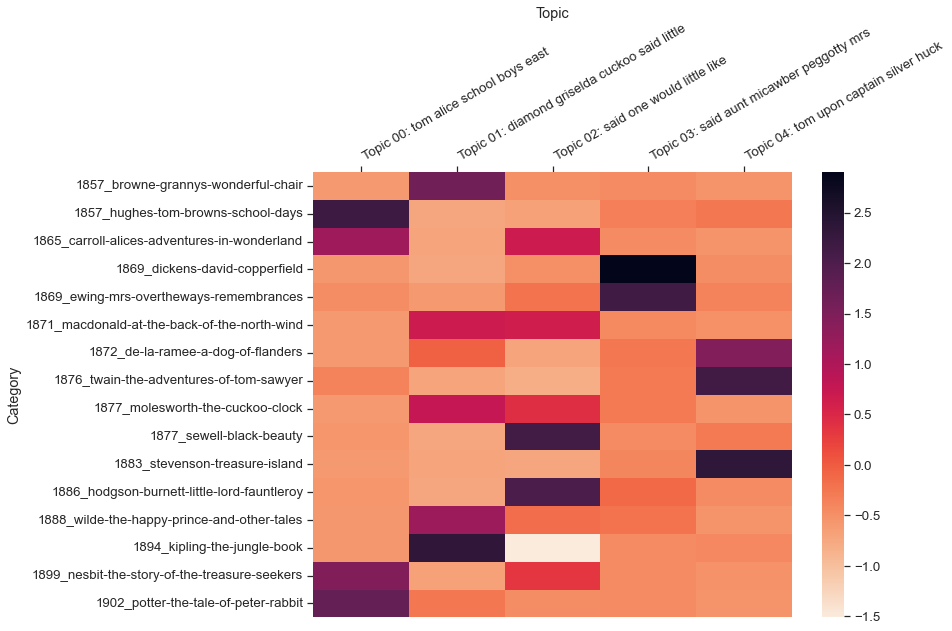

In [33]:
little_mallet_wrapper.plot_categories_by_topics_heatmap(book_titles,
                                      topic_distributions,
                                      topics, 
                                      output_directory_path + '/categories_by_topics.pdf',
                                      target_labels=target_labels,
                                      dim= (13, 9)
                                     )

The darker squares in this heatmap represent a high probability for the corresponding topic (compared to everyone else in the heatmap) and the lighter squares in the heatmap represent a low probability for the corresponding topic.

## Display Top Titles Per Topic

We can also display the obituaries that have the highest probability for every topic with the `little_mallet_wrapper.get_top_docs()` function.

Because most of the obituaries in our corpus are pretty long, however, it will be more useful for us to simply display the title of each obituary, rather than the entire document—at least as a first step. To do so, we'll first need to make two dictionaries, which will allow us to find the corresponding obituary title and the original text from a given training document.

In [34]:
training_data_book_titles = dict(zip(training_data, book_titles))
training_data_original_text = dict(zip(training_data, original_texts))

Then we'll make our own function `display_top_titles_per_topic()` that will display the top text titles for every topic. This function accepts a given `topic_number` as well as a desired `number_of_documents` to display.

In [35]:
def display_top_titles_per_topic(topic_number=0, number_of_documents=5):
    
    print(f"Topic {topic_number}\n\n{topics[topic_number]}\n")

    for probability, document in little_mallet_wrapper.get_top_docs(training_data, topic_distributions, topic_number, n=number_of_documents):
        print(round(probability, 4), training_data_book_titles[document] + "\n")
    return

**Topic 0**

To display the top 5 obituary titles with the highest probability of containing Topic 0, we will run:

In [36]:
display_top_titles_per_topic(topic_number=0, number_of_documents=5)

Topic 0

['tom', 'alice', 'school', 'boys', 'east', 'half', 'oswald', 'one', 'arthur', 'two', 'old', 'doctor', 'noel', 'get', 'dicky', 'house', 'time', 'dora', 'away', 'uncle']

0.459 1857_hughes-tom-browns-school-days

0.3889 1902_potter-the-tale-of-peter-rabbit

0.3397 1899_nesbit-the-story-of-the-treasure-seekers

0.2894 1865_carroll-alices-adventures-in-wonderland

0.0377 1876_twain-the-adventures-of-tom-sawyer

